In [1]:
from Model import *
from Image import *

In [2]:
import time

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# desired size of the output im
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

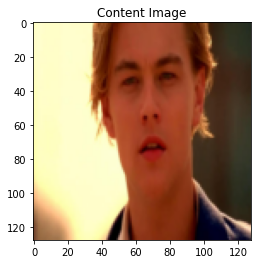

In [4]:
content_img = image_loader("c1.jpg")

plt.figure()
imshow(content_img, title='Content Image')

In [5]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [23]:
def get_imgs_name(file):
    """ Get images name form a txt file

    input:
        file (str): name of the txt file
        path: prefix of the system path

    output:
        names (list): the name of this type of img
        imgs (list): a list store the path of the image
    """
    names = []
    imgs = []

    with open(file, 'r') as f:
        s = f.readline().strip('\n').split('/')
        names.append(s[0])
        imgs.append(''.join(s[1:]))

    return names, imgs

In [24]:
names, imgs = get_imgs_name('../test/test_banded1.txt')
imgs

['banded_0002.jpg']

In [25]:
# desired depth layers to compute style/content losses:
default_content_layers = ['conv_4']
default_style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [26]:
def tansfer(cnn, content_img, style_img, style_name, file, 
            num_output = 5,
            default_content_layers = ['conv_4'],
            default_style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
    """

    file (str):
    """
    out_imgs = []
    scores = 0

    for i in range(num_output):
        input_img = generate_input_image(noise = False, content_img=content_img)

        output, g, times = style_transfer(cnn, content_img, style_img, input_img,
        default_mean_std = False, 
        num_steps=300, 
        style_weight=1000000, 
        content_weight=1)
        
        # save fig
        out_imgs.append(output)
        save_name = '{}_{}'.format(style_name, i)
        torchvision.utils.save_image(output, file + '{}.jpg'.format(save_name))
        plt.scatter(range(len(times))[::10], times[::10], 
        marker='x', linewidths=1,label=str(i))
        
    plt.savefig(file + '{} time'.format(save_name))

    return out_imgs

In [27]:
def generate(cnn, content_img, txt_file, saving_path, 
            img_path = '../src/dtd/images/',
            num_output = 5,
            default_content_layers = ['conv_4'],
            default_style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):

            names, imgs = get_imgs_name(txt_file)

            for name, img in zip(names, imgs):
                this_saving_path = saving_path + '/' + name
                style_name = name
                img = img_path + name + '/' + img
                style_img = image_loader(img)
                tansfer(cnn, content_img, style_img, style_name, this_saving_path)


Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 1444.125488 Content Loss: 41.281876

run [100]:
Style Loss : 495.183044 Content Loss: 46.833946

run [150]:
Style Loss : 262.931824 Content Loss: 48.855511

run [200]:
Style Loss : 166.479507 Content Loss: 49.743874

run [250]:
Style Loss : 121.050591 Content Loss: 50.431473

run [300]:
Style Loss : 93.019737 Content Loss: 50.865013

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 1444.125488 Content Loss: 41.281876

run [100]:
Style Loss : 495.183044 Content Loss: 46.833946

run [150]:
Style Loss : 262.931824 Content Loss: 48.855511

run [200]:
Style Loss : 166.479507 Content Loss: 49.743874

run [250]:
Style Loss : 121.050591 Content Loss: 50.431473

run [300]:
Style Loss : 93.019737 Content Loss: 50.865013

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 1444.125488 Content Loss: 41.281876

run [100]:
Style Loss : 495.183044 Content Loss: 46.833946

run [150]:
Styl

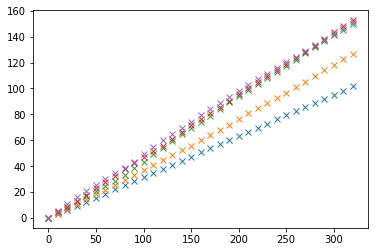

In [28]:
generate(cnn, content_img, 
        txt_file = '../test/test_banded1.txt', 
        saving_path = '../transfered_output/',
        num_output = 2,
        default_content_layers = ['conv_4'],
        default_style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'])